# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
- Where and when do major power outages tend to occur?
- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?
- What characteristics are associated with each category of cause?
- How have characteristics of major power outages changed over time? Is there a clear trend?

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
   The dataset consists of major outage happened during January 2000–July 2016. The definition of "major outage" is mentioned in the first section of this notebook. My final objective is to test whether major outage tends to happen in warm days.

### Cleaning and EDA
1. Read in the data and transform it to usable data by trimming rows and columns that don't contain any data. It doesn't affect the data.
2. Dropped 22 rows that have lots of values missing. Since the number of rows dropped is relatively small, it will not skew the dataset too much.
3. Looked into columns CAUSE.CATEGORY and CAUSE.CATEGORY.DETAIL by ploting them in a bar chart. We can see that in some categories, certain sub-categories(CAUSE.CATEGORY.DETAIL) has significantly higher occurences than others.

### Assessment of Missingness
   I believe that some columns with many missing values might be NMAR. For example, DEMAND.LOSS.MW might be missing becuase the impacted region didn't set up the mechnism to calculate the loss. This is not at random and has something to do with the data generating process itself. In order to explain the missingness, the most needed information is whether the impacted region has this mechnism. 
1. OUTAGE.RESTORATION.DATE, OUTAGE.RESTORATION.TIME and OUTAGE.RESTORATION.DATE are missing by design.
2. The missingness of CAUSE.CATEGORY.DETAIL is dependent on CAUSE.CATEGORY.
3. CUSTOMERS.AFFECTED is MAR with respect to many columns, including YEAR and MONTH. However, it's MCAR with respect to columns such as CLIMATE.CATEGORY and RES.PRICE.

### Hypothesis Test
- I tested whether major outages happen more often in a specific month. After looking at the original distribution of months, I decided to choose June.
- I first selected columns that I need and got the observed value. Then I run a 1000 permutation test and calculate the probability that an outage happens in June in each permutation.
- The result I got shows that June does have a higher outage rate.

# Code

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [73]:
#read excel
outage = pd.read_excel('outage.xlsx')
outage.head()

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND


The first few rows are actually introduction to the excel worksheet, and we need to get rid of them. Also the sixth row is a description of some columns, which is not part of the data. The first column consists of the labels of the indices and the columns('variables', 'Units'), which should be gotten rid of too.

In [74]:
#drop useless rows and columns
outage = outage.drop([0, 1, 2, 3, 5])
outage = outage.iloc[:, 1:]
outage.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
4,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
6,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
7,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
8,3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
9,4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


We should set the first row as the column labels and the first column as the row indices.

In [75]:
outage.columns = outage.iloc[0]
outage = outage.iloc[1:]
outage = outage.set_index('OBS', drop = True)
outage.head()

4,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


In [76]:
outage.describe()

4,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
count,1534,1525,1534,1534,1534,1528,1525.0,1525,1525,1525,...,1534.00,1534.00,1534.0,1524.0,1524.0,1534.00,1534.00,1534.000000,1534.000000,1534.000000
unique,17,12,50,50,14,9,36.0,3,1028,622,...,50.00,50.00,50.0,49.0,47.0,46.00,46.00,50.000000,50.000000,50.000000
top,2011,6,California,CA,WECC,Northeast,-0.3,normal,2012-10-29 00:00:00,15:00:00,...,94.95,5.22,4303.7,2124.1,12.7,5.28,0.59,95.164177,4.835823,1.730658
freq,269,195,210,210,451,350,191.0,744,19,35,...,210.00,210.00,210.0,210.0,210.0,210.00,210.00,210.000000,210.000000,210.000000


In [77]:
outage['CAUSE.CATEGORY.DETAIL'].unique()

array([nan, 'vandalism', 'heavy wind', 'thunderstorm', 'winter storm',
       'tornadoes', 'sabotage', 'hailstorm', 'uncontrolled loss',
       'winter', 'wind storm', 'computer hardware', 'public appeal',
       'storm', ' Coal', ' Natural Gas', 'hurricanes', 'wind/rain',
       'snow/ice storm', 'snow/ice ', 'transmission interruption',
       'flooding', 'transformer outage', 'generator trip',
       'relaying malfunction', 'transmission trip', 'lightning',
       'switching', 'shed load', 'line fault', 'breaker trip', 'wildfire',
       ' Hydro', 'majorsystem interruption', 'voltage reduction',
       'transmission', 'Coal', 'substation', 'heatwave',
       'distribution interruption', 'wind', 'suspicious activity',
       'feeder shutdown', '100 MW loadshed', 'plant trip', 'fog', 'Hydro',
       'earthquake', 'HVSubstation interruption', 'cables', 'Petroleum',
       'thunderstorm; islanding', 'failure'], dtype=object)

Let's see which columns have missing values.

In [78]:
outage.isnull().sum()

4
YEAR                          0
MONTH                         9
U.S._STATE                    0
POSTAL.CODE                   0
NERC.REGION                   0
CLIMATE.REGION                6
ANOMALY.LEVEL                 9
CLIMATE.CATEGORY              9
OUTAGE.START.DATE             9
OUTAGE.START.TIME             9
OUTAGE.RESTORATION.DATE      58
OUTAGE.RESTORATION.TIME      58
CAUSE.CATEGORY                0
CAUSE.CATEGORY.DETAIL       471
HURRICANE.NAMES            1462
OUTAGE.DURATION              58
DEMAND.LOSS.MW              705
CUSTOMERS.AFFECTED          443
RES.PRICE                    22
COM.PRICE                    22
IND.PRICE                    22
TOTAL.PRICE                  22
RES.SALES                    22
COM.SALES                    22
IND.SALES                    22
TOTAL.SALES                  22
RES.PERCEN                   22
COM.PERCEN                   22
IND.PERCEN                   22
RES.CUSTOMERS                 0
COM.CUSTOMERS                 0
IND.CU

In [79]:
#check rows with null month
null_month = outage.loc[outage['MONTH'].isnull()]
null_month.isnull().sum()

4
YEAR                       0
MONTH                      9
U.S._STATE                 0
POSTAL.CODE                0
NERC.REGION                0
CLIMATE.REGION             1
ANOMALY.LEVEL              9
CLIMATE.CATEGORY           9
OUTAGE.START.DATE          9
OUTAGE.START.TIME          9
OUTAGE.RESTORATION.DATE    9
OUTAGE.RESTORATION.TIME    9
CAUSE.CATEGORY             0
CAUSE.CATEGORY.DETAIL      1
HURRICANE.NAMES            9
OUTAGE.DURATION            9
DEMAND.LOSS.MW             3
CUSTOMERS.AFFECTED         2
RES.PRICE                  9
COM.PRICE                  9
IND.PRICE                  9
TOTAL.PRICE                9
RES.SALES                  9
COM.SALES                  9
IND.SALES                  9
TOTAL.SALES                9
RES.PERCEN                 9
COM.PERCEN                 9
IND.PERCEN                 9
RES.CUSTOMERS              0
COM.CUSTOMERS              0
IND.CUSTOMERS              0
TOTAL.CUSTOMERS            0
RES.CUST.PCT               0
COM.CUST.PCT

We can see that rows with month missing also has many other values missing. Since 9 is very small compared to the size of the dataframe, which consists of 1534 rows, we can just ignore these rows.

In [80]:
#drop rows with missing values in the MONTH column
outage = outage.loc[outage['MONTH'].notnull()]
outage.isnull().sum()

4
YEAR                          0
MONTH                         0
U.S._STATE                    0
POSTAL.CODE                   0
NERC.REGION                   0
CLIMATE.REGION                5
ANOMALY.LEVEL                 0
CLIMATE.CATEGORY              0
OUTAGE.START.DATE             0
OUTAGE.START.TIME             0
OUTAGE.RESTORATION.DATE      49
OUTAGE.RESTORATION.TIME      49
CAUSE.CATEGORY                0
CAUSE.CATEGORY.DETAIL       470
HURRICANE.NAMES            1453
OUTAGE.DURATION              49
DEMAND.LOSS.MW              702
CUSTOMERS.AFFECTED          441
RES.PRICE                    13
COM.PRICE                    13
IND.PRICE                    13
TOTAL.PRICE                  13
RES.SALES                    13
COM.SALES                    13
IND.SALES                    13
TOTAL.SALES                  13
RES.PERCEN                   13
COM.PERCEN                   13
IND.PERCEN                   13
RES.CUSTOMERS                 0
COM.CUSTOMERS                 0
IND.CU

Next let's examine the RES.PRICE column, since this is one of the several columns that have the same number of missingness. If they are missing in the same place, we can drop them too.

In [81]:
null_res = outage.loc[outage['RES.PRICE'].isnull()]
null_res.isnull().sum()

4
YEAR                        0
MONTH                       0
U.S._STATE                  0
POSTAL.CODE                 0
NERC.REGION                 0
CLIMATE.REGION              0
ANOMALY.LEVEL               0
CLIMATE.CATEGORY            0
OUTAGE.START.DATE           0
OUTAGE.START.TIME           0
OUTAGE.RESTORATION.DATE     1
OUTAGE.RESTORATION.TIME     1
CAUSE.CATEGORY              0
CAUSE.CATEGORY.DETAIL       6
HURRICANE.NAMES            13
OUTAGE.DURATION             1
DEMAND.LOSS.MW              5
CUSTOMERS.AFFECTED          4
RES.PRICE                  13
COM.PRICE                  13
IND.PRICE                  13
TOTAL.PRICE                13
RES.SALES                  13
COM.SALES                  13
IND.SALES                  13
TOTAL.SALES                13
RES.PERCEN                 13
COM.PERCEN                 13
IND.PERCEN                 13
RES.CUSTOMERS               0
COM.CUSTOMERS               0
IND.CUSTOMERS               0
TOTAL.CUSTOMERS             0
RES.CUST

Indeed, 13 rows have missingness in the same columns, we can drop them, because the size is relatively small.

In [82]:
outage = outage.loc[outage['RES.PRICE'].notnull()]
outage.isnull().sum()

4
YEAR                          0
MONTH                         0
U.S._STATE                    0
POSTAL.CODE                   0
NERC.REGION                   0
CLIMATE.REGION                5
ANOMALY.LEVEL                 0
CLIMATE.CATEGORY              0
OUTAGE.START.DATE             0
OUTAGE.START.TIME             0
OUTAGE.RESTORATION.DATE      48
OUTAGE.RESTORATION.TIME      48
CAUSE.CATEGORY                0
CAUSE.CATEGORY.DETAIL       464
HURRICANE.NAMES            1440
OUTAGE.DURATION              48
DEMAND.LOSS.MW              697
CUSTOMERS.AFFECTED          437
RES.PRICE                     0
COM.PRICE                     0
IND.PRICE                     0
TOTAL.PRICE                   0
RES.SALES                     0
COM.SALES                     0
IND.SALES                     0
TOTAL.SALES                   0
RES.PERCEN                    0
COM.PERCEN                    0
IND.PERCEN                    0
RES.CUSTOMERS                 0
COM.CUSTOMERS                 0
IND.CU

Now we have cleared rows with lots of data missing. We have dropped 22 rows in total, which will not largely affect our data. We will base our analysis on this dataset.

There are lots of nans in the CAUSE.CATEGORY.DETAIL column. Let's see how the column look like.

In [84]:
#strip all characters in the column
outage['CAUSE.CATEGORY.DETAIL'] = pd.Series([x.strip() if type(x) == str else x for x in outage['CAUSE.CATEGORY.DETAIL']])
outage['CAUSE.CATEGORY.DETAIL'].head()

OBS
1      heavy wind
2    thunderstorm
3             NaN
4    winter storm
5       tornadoes
Name: CAUSE.CATEGORY.DETAIL, dtype: object

In [85]:
#statistics of CAUSE.CATEGORY.DETAIL
cause_detail = outage['CAUSE.CATEGORY.DETAIL']
cause_detail.describe()

count          1022
unique           48
top       vandalism
freq            323
Name: CAUSE.CATEGORY.DETAIL, dtype: object

In [90]:
#number of occurences of each cause
cause_detail.to_frame().groupby('CAUSE.CATEGORY.DETAIL')['CAUSE.CATEGORY.DETAIL'].count().sort_values(ascending = False)

CAUSE.CATEGORY.DETAIL
vandalism                    323
thunderstorm                 170
winter storm                  99
hurricanes                    72
heavy wind                    59
storm                         40
sabotage                      28
wildfire                      25
winter                        23
transmission interruption     18
Coal                          17
generator trip                16
snow/ice                      13
wind/rain                     12
uncontrolled loss             12
heatwave                      10
tornadoes                      8
Natural Gas                    7
Hydro                          6
transmission trip              6
wind storm                     6
breaker trip                   4
flooding                       4
earthquake                     4
suspicious activity            3
hailstorm                      3
wind                           3
transmission                   3
lightning                      3
distribution interrup

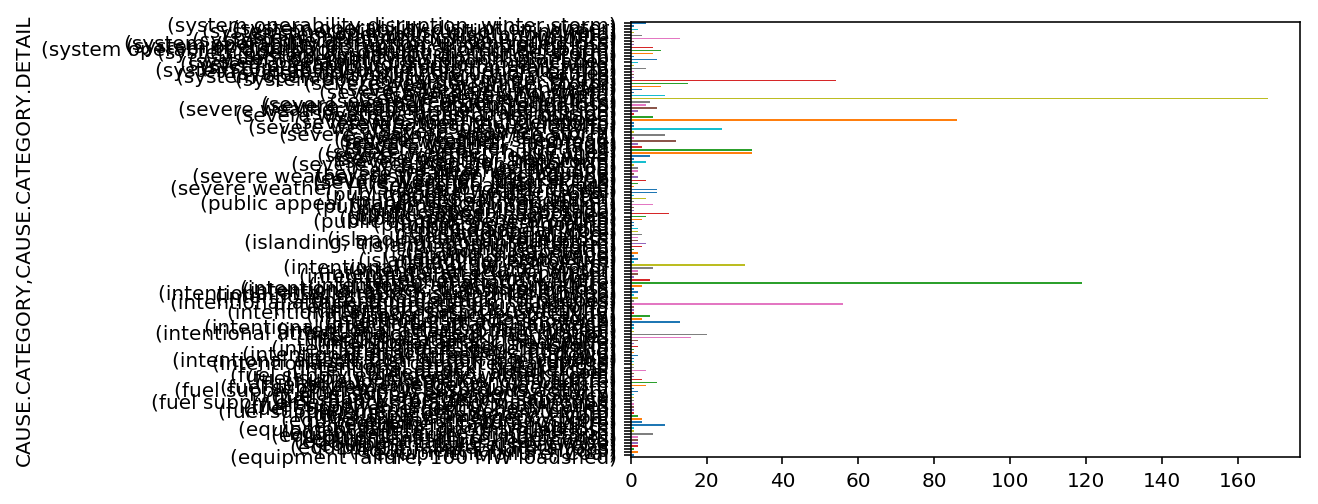

In [165]:
#create a pivot table with CAUSE.CATEGORY as indices and CAUSE.CATEGORY.DETAIL as columns
outage.groupby(['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL'])['YEAR'].count().plot(kind = 'barh')

Though the labels are dense and hard to tell, but we can see that in some categories, there are certain sub-categories that have high occurences.

### Assessment of Missingness

It seems that OUTAGE.RESTORATION.DATE, OUTAGE.RESTORATION.TIME and OUTAGE.RESTORATION.DATE might be missing by design. This makes intuitive sense, since they are closely related. Let's check them out.

In [39]:
restoration_date_null = outage.loc[outage['OUTAGE.RESTORATION.DATE'].isnull()]
restoration_date_null.isnull().sum()

4
YEAR                        0
MONTH                       0
U.S._STATE                  0
POSTAL.CODE                 0
NERC.REGION                 0
CLIMATE.REGION              0
ANOMALY.LEVEL               0
CLIMATE.CATEGORY            0
OUTAGE.START.DATE           0
OUTAGE.START.TIME           0
OUTAGE.RESTORATION.DATE    48
OUTAGE.RESTORATION.TIME    48
CAUSE.CATEGORY              0
CAUSE.CATEGORY.DETAIL      22
HURRICANE.NAMES            47
OUTAGE.DURATION            48
DEMAND.LOSS.MW             29
CUSTOMERS.AFFECTED         20
RES.PRICE                   0
COM.PRICE                   0
IND.PRICE                   0
TOTAL.PRICE                 0
RES.SALES                   0
COM.SALES                   0
IND.SALES                   0
TOTAL.SALES                 0
RES.PERCEN                  0
COM.PERCEN                  0
IND.PERCEN                  0
RES.CUSTOMERS               0
COM.CUSTOMERS               0
IND.CUSTOMERS               0
TOTAL.CUSTOMERS             0
RES.CUST

Therefore, we can conclude that OUTAGE.RESTORATION.DATE, OUTAGE.RESTORATION.TIME and OUTAGE.RESTORATION.DATE are missing by design.

Next, we want to check whether the missingness of CAUSE.CATEGORY.DETAIL is dependent on CAUSE.CATEGORY. We set alpha = 0.05

In [112]:
df = outage[['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL']].copy()
df.head()

4,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL
OBS,,
1,severe weather,heavy wind
2,intentional attack,thunderstorm
3,severe weather,NaN
4,severe weather,winter storm
5,severe weather,tornadoes


In [113]:
#observed value
gpA = df.loc[df['CAUSE.CATEGORY.DETAIL'].isnull(), 'CAUSE.CATEGORY']
gpB = df.loc[df['CAUSE.CATEGORY.DETAIL'].notnull(), 'CAUSE.CATEGORY']
obs = ks_2samp(gpA, gpB).statistic
obs

0.0659491193737769

In [119]:
#permutation
copy = df.copy()
perm_results = []
for i in range(100):
    copy['CAUSE.CATEGORY.DETAIL'] = df['CAUSE.CATEGORY.DETAIL'].sample(frac = 1, replace = False).reset_index(drop = True)
    gpA = copy.loc[copy['CAUSE.CATEGORY.DETAIL'].isnull(), 'CAUSE.CATEGORY']
    gpB = copy.loc[copy['CAUSE.CATEGORY.DETAIL'].notnull(), 'CAUSE.CATEGORY']
    perm_results.append(ks_2samp(gpA, gpB).statistic)
pval = np.mean(np.array(perm_results) >= obs)
pval

0.01

Therefore, we can conclude that the missingness in CAUSE.CATEGORY.DETAIL is dependent on CAUSE.CATEGORY.

Now let's test whether missingness in CUSTOMERS.AFFECTED is dependent on any columns in the dataset.

In [134]:
result = {}
for col in outage.columns:
    #exclude columns with missing values
    if (outage[col].isnull().sum() == 0):
        df = outage[['CUSTOMERS.AFFECTED', col]].copy()

        #observed value
        gpA = df.loc[df['CUSTOMERS.AFFECTED'].isnull(), col]
        gpB = df.loc[df['CUSTOMERS.AFFECTED'].notnull(), col]
        obs = ks_2samp(gpA, gpB).statistic

        #permutation
        copy = df.copy()
        perm_results = []
        for i in range(100):
            copy['CUSTOMERS.AFFECTED'] = df['CUSTOMERS.AFFECTED'].sample(frac = 1, replace = False).reset_index(drop = True)
            gpA = copy.loc[copy['CUSTOMERS.AFFECTED'].isnull(), col]
            gpB = copy.loc[copy['CUSTOMERS.AFFECTED'].notnull(), col]
            perm_results.append(ks_2samp(gpA, gpB).statistic)
        pval = np.mean(np.array(perm_results) >= obs)
        result[col] = pval
pd.Series(result)

YEAR                 0.00
MONTH                0.00
U.S._STATE           0.00
POSTAL.CODE          0.00
NERC.REGION          0.00
ANOMALY.LEVEL        0.00
CLIMATE.CATEGORY     0.31
OUTAGE.START.DATE    0.00
OUTAGE.START.TIME    0.00
CAUSE.CATEGORY       0.00
RES.PRICE            0.12
COM.PRICE            0.00
IND.PRICE            0.00
TOTAL.PRICE          0.25
RES.SALES            0.00
COM.SALES            0.00
IND.SALES            0.02
TOTAL.SALES          0.00
RES.PERCEN           0.65
COM.PERCEN           0.56
IND.PERCEN           0.11
RES.CUSTOMERS        0.00
COM.CUSTOMERS        0.00
IND.CUSTOMERS        0.00
TOTAL.CUSTOMERS      0.00
RES.CUST.PCT         0.00
COM.CUST.PCT         0.04
IND.CUST.PCT         0.00
PC.REALGSP.STATE     0.00
PC.REALGSP.USA       0.00
PC.REALGSP.REL       0.00
PC.REALGSP.CHANGE    0.05
UTIL.REALGSP         0.00
TOTAL.REALGSP        0.00
UTIL.CONTRI          0.00
PI.UTIL.OFUSA        0.00
POPULATION           0.00
POPPCT_URBAN         0.00
POPPCT_UC   

We can see that CUSTOMERS.AFFECTED is MAR with respect to many columns, including YEAR and MONTH. However, it's MCAR with respect to columns such as CLIMATE.CATEGORY and RES.PRICE.

### Hypothesis Test

I want to test whether a specific month is related to major outages. We first select only the MONTH column. 

In [143]:
#choose only the CLIMATE.CATEGORY column
month = outage[['YEAR', 'MONTH']]
month

4,YEAR,MONTH
OBS,,
1,2011,7
2,2014,5
3,2010,10
4,2012,6
5,2015,7
6,2010,11
7,2010,7
8,2005,6
9,2015,3


In [147]:
#outages happened by month
outages_by_month = month.groupby('MONTH')['YEAR'].count() / len(month)
outages_by_month

MONTH
1     0.089947
2     0.089947
3     0.066138
4     0.073413
5     0.083995
6     0.128968
7     0.111111
8     0.101190
9     0.062169
10    0.072090
11    0.047619
12    0.073413
Name: YEAR, dtype: float64

We can see that June has the highest proportion of outages, so we will look into that. The null hypothesis is that the outage rate in June is the same as that of other months. The alternative hypothesis is that an outage has a higher probability happening in June. The observed value is:

In [148]:
obs = outages_by_month.loc[6]
obs

0.12896825396825398

Under the null hypothesis, the probability that an outage happens in June and not in June is:

In [145]:
p = [30/365, 335/365]
p

[0.0821917808219178, 0.9178082191780822]

Next, we do a permutation test of 1000 permutations. We set alpha = 0.05.

0.0

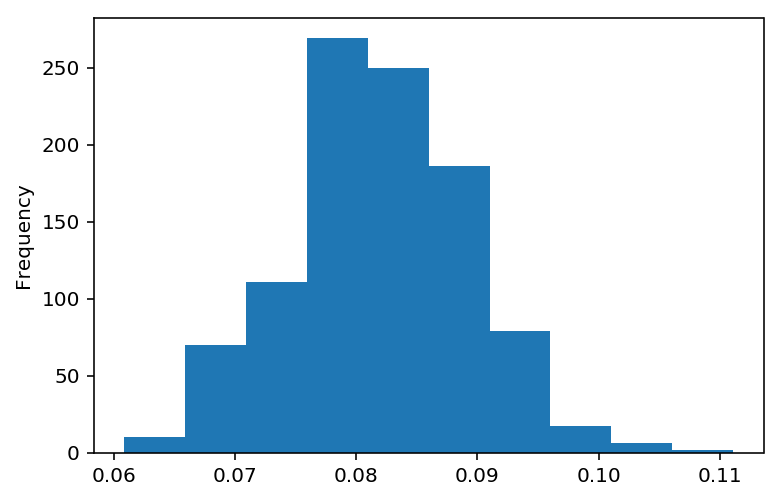

In [158]:
test_results = []
copy = month.copy()
for i in range(1000):
    copy['MONTH'] = pd.Series(range(1, 13)).sample(len(month), replace = True).reset_index(drop = True)
    by_month = copy.groupby('MONTH')['YEAR'].count() / len(copy)
    test_results.append(by_month.loc[6])
pval = (np.array(test_results) >= obs).mean()
pd.Series(test_results).plot(kind = 'hist')
pval

So we reject the null hypothesis. Therefore, we conclude that June has a higher outage rates than other months.